In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [6]:
RAW_FILE = 'src_data/mpox_pgraph.csv'
pop_data = pd.read_csv('src_data/population.csv')
infection_chance_per_day=[0.2,0.3,0.2,0.1]
cbgNames = set()
trans_data = {}

In [7]:
isheader = True
with open(RAW_FILE, 'r') as f:
    for line in f.readlines():
        if isheader:
            isheader = False
            continue
        cbgNames.add(line.strip().split(',')[0])
cbgNames = list(cbgNames)

In [8]:
isheader = True
with open(RAW_FILE, 'r') as f:
    for line in f.readlines():
        if isheader:
            isheader = False
            continue
        
        line = line.strip().split(',')
        fromCBG = cbgNames.index(line[0])
        toCBG = cbgNames.index(line[1])
        if fromCBG not in trans_data:
            trans_data[fromCBG] = []
            trans_data[fromCBG].append([])
            trans_data[fromCBG].append([])
        trans_data[fromCBG][0].append(toCBG)
        trans_data[fromCBG][1].append(float(line[3]))

In [9]:
nCBG = len(trans_data)

In [10]:
def idx_with_rand_probs(probs):
    val = random.random()
    cumuProb = 0
    for i, prob in enumerate(probs):
        cumuProb += prob
        if val < cumuProb:
            return i
    return -1

In [71]:
population = []
for cbg in cbgNames:
    population.append(pop_data[pop_data['GeoId'] == int(cbg)]['Population'].item())


In [94]:
def initCase(numInitCase, cbgSIR, active_cases, newCaseIdx = None):
    if newCaseIdx is None:
        newCaseIdx = random.randint(0, nCBG - 1)
    
    numInitCase = min(numInitCase, cbgSIR['S'][newCaseIdx])
    cbgSIR['S'][newCaseIdx] -= numInitCase
    cbgSIR['I'][newCaseIdx] += numInitCase
    
    for _ in range(int(numInitCase)):
        active_cases.append([newCaseIdx, 0])
    
    return numInitCase, newCaseIdx

def newCase(cbdIdx, cbgSIR, active_cases):
    
    srcCBGTrans = trans_data[cbdIdx]
    desCBGIdx = idx_with_rand_probs(srcCBGTrans[1])
    desCBG = srcCBGTrans[0][desCBGIdx]

    active_cases.append([desCBG, 0])
    cbgSIR['S'][desCBG] -= 1
    cbgSIR['I'][desCBG] += 1
    
    
    if cbgSIR['S'][desCBG] == 0:
        srcCBGTrans[0].pop(desCBGIdx)
        val = srcCBGTrans[1].pop(desCBGIdx)
        val = 1-val
        for i in range(len(srcCBGTrans[1])):
            srcCBGTrans[1][i] /= val




In [93]:
def nextDay(cbgSIR, active_cases):
    i = 0
    while i < len(active_cases):
        case = active_cases[i]
        
        # Recovered
        if case[1] == len(infection_chance_per_day):
            cbgIdx = case[0]
            cbgSIR['I'][cbgIdx] -= 1
            cbgSIR['R'][cbgIdx] += 1

            active_cases.pop(i)
            # print('Recovered')
            continue
        
        infectionChance = infection_chance_per_day[case[1]]
        case[1] += 1
        i += 1
        
        if random.random() > infectionChance:
            # print('Unlucky')
            continue
        
        # One new case exist
        newCase(case[0], cbgSIR, active_cases)
        # print('Infected')
        

In [109]:
def startSimu(numInit, newCaseIdx = None):
    active_cases = []
    cbgSIR = {'S':np.array(population), 'I':np.zeros(nCBG), 'R':np.zeros(nCBG)}
    numInit,newCaseIdx = initCase(numInit, cbgSIR, active_cases,newCaseIdx)
    IPerDay = [numInit]
    for i in range(30):
        nextDay(cbgSIR, active_cases)
        IPerDay.append(np.sum(cbgSIR['I']))
    plt.plot(IPerDay)
    print(newCaseIdx)

317


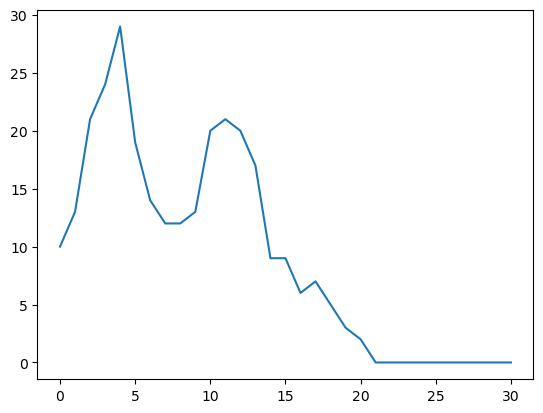

In [115]:
startSimu(10)